In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks

Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669


Example 1 - Image shape: (256, 256, 3)
Example 1 - Label =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Example 1 - Mask shape: (256, 256, 1)


Example 2 - Image shape: (256, 256, 3)
Example 2 - Label =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Example 2 - Mask shape: (256, 256, 1)




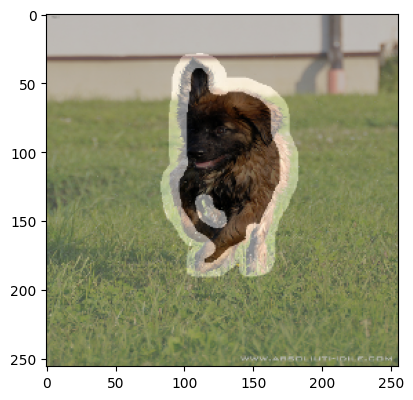

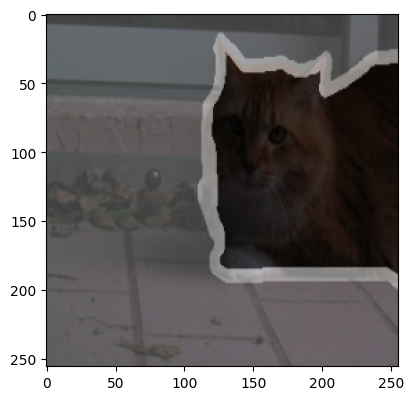

In [2]:
from data_loading import OxfordPetDataset
from augmentation import random_flip, augmentation_layers
from models import UNet_model
from experiment import plot_results

# Load the data
dataset = OxfordPetDataset()
dataset.load_data()
dataset.one_hot_encoding()

# Resize and normalize
reshape_size = (256, 256)
dataset.res_norm(reshape_size)

train = dataset.train_raw
val = dataset.val_raw
test = dataset.test_raw
ds_info = dataset.ds_info
get_label_name = dataset.get_label_name

print("\n")

for i, example in enumerate(test.take(2)):  # Take two examples
    print(f"Example {i+1} - Image shape:", example['image'].shape)
    image = example['image']
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, i+1)
    plt.imshow(image)
    label = example['label']
    print(f"Example {i+1} - Label = ", label.numpy())
    mask = example['segmentation_mask']  # This is the segmentation mask
    plt.imshow(mask, cmap='gray', alpha=0.5)
    print(f"Example {i+1} - Mask shape:", mask.numpy().shape)
    print("\n")
plt.show()

In [3]:
train

<_MapDataset element_spec={'image': TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), 'label': TensorSpec(shape=(37,), dtype=tf.float32, name=None), 'segmentation_mask': TensorSpec(shape=(256, 256, 1), dtype=tf.float32, name=None)}>

In [4]:
augmentation = augmentation_layers()

AttributeError: module 'keras._tf_keras.keras.layers' has no attribute 'RandomSaturation'

NameError: name 'augmentation' is not defined

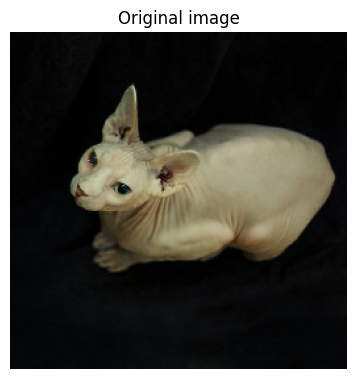

In [ ]:
for example in train.take(1):
    image = example['image']
    
    plt.figure(figsize=(20, 5))
    
    # Plot original image
    plt.subplot(1, 4, 1)
    plt.title("Original image")
    plt.imshow(image)
    plt.axis("off")
    
    # Plot augmented images
    for i in range(3):
        aug_img = augmentation(tf.expand_dims(image, axis=0))
        plt.subplot(1, 4, i+2)
        plt.title(f"Augmented image {i+1}")
        plt.imshow(aug_img[0])
        plt.axis("off")

plt.show()

In [ ]:
BATCH_SIZE = 32

# Batch the data and use prefetching to optimize loading speed
# AVOID use of caching (Google Colab RAM limits)

train_ds = train.batch(batch_size=BATCH_SIZE, 
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

val_ds = val.batch(batch_size=BATCH_SIZE, 
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)
                      
test_ds = test.batch(batch_size=BATCH_SIZE, 
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Create model components
augmentation = augmentation_layers()
unet = UNet_model(input_shape=reshape_size + (3,))

# Build combined architecture
inputs = tf.keras.Input(shape=reshape_size + (3,))
x = augmentation(inputs)      # Apply augmentations and normalization
outputs = unet(x)             # Pass through UNet
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer='adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [ ]:
history = model.fit(train, epochs=2, validation_data=val)

Epoch 1/2


ValueError: Missing data for input "input_layer_6". You passed a data dictionary with keys ['image', 'label', 'segmentation_mask']. Expected the following keys: ['input_layer_6']

Implementation of Autoencoder ( Task 2b )

In [5]:
dataset = OxfordPetDataset()
dataset.load_data()
dataset.one_hot_encoding()
dataset.res_norm((256, 256))

Number of classes: 37
Number of training samples: 3312
Number of validation samples: 368
Number of test samples: 3669


Extracts only the image data (ignoring segmentation masks).
Batches the dataset with a batch size of 32.

1️⃣ Trained an Autoencoder to learn features from raw images.
2️⃣ Saved the encoder and used it as a feature extractor for segmentation.
3️⃣ Built a segmentation model (new decoder) to predict masks.
4️⃣ Trained the segmentation model using labeled masks.
5️⃣ Predicted a segmentation mask for a new input image.

Expected Results
The autoencoder encoder improves segmentation by learning useful features first.
Segmentation model outputs a grayscale mask (1 = object, 0 = background).
Better accuracy compared to training from scratch.

In [6]:
train_images = dataset.train_raw.map(lambda x: (x['image'], x['image'])).batch(32)
val_images = dataset.val_raw.map(lambda x: (x['image'], x['image'])).batch(32)


In [7]:
from autoencoder import Autoencoder

In [8]:
autoencoder = Autoencoder(input_shape=(256, 256, 3))
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(train_images, validation_data=val_images, epochs=20)



Epoch 1/20


c:\Users\vidia\anaconda3\envs\mlp\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 426s 4s/step - loss: 0.0415 - val_loss: 0.0074
Epoch 2/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 364s 3s/step - loss: 0.0071 - val_loss: 0.0052
Epoch 3/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 381s 4s/step - loss: 0.0055 - val_loss: 0.0048
Epoch 4/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 373s 4s/step - loss: 0.0048 - val_loss: 0.0041
Epoch 5/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - loss: 0.0041 - val_loss: 0.0039
Epoch 6/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - loss: 0.0039 - val_loss: 0.0036
Epoch 7/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - loss: 0.0037 - val_loss: 0.0034
Epoch 8/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - loss: 0.0036 - val_loss: 0.0040
Epoch 9/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 374s 4s/step - loss: 0.0035 - val_loss: 0.0033
Epoch 10/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 414s 4s/step - loss: 0.0033 - val_loss: 0.0031
Epoch 11/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 437s 4s/step - loss: 0.0031 - val_loss: 0.0031
Epoch 12/20
104/104 ━━━━━━━━━━━━━━━━━━━━ 431s 4s/ste

In [ ]:
num_samples = 5
sample_images = val_images[:num_samples]
reconstructed_images = autoencoder.predict(sample_images)

# Plot original and reconstructed images
fig, axes = plt.subplots(num_samples, 2, figsize=(6, num_samples * 2))
for i in range(num_samples):
    axes[i, 0].imshow(sample_images[i])
    axes[i, 0].set_title("Original")
    axes[i, 0].axis("off")
    
    axes[i, 1].imshow(reconstructed_images[i])
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

# Save trained model
autoencoder.save("autoencoder_model.h5")

Save Trained Models

In [ ]:
autoencoder.save_weights("autoencoder.weights.h5")  # ✅ Correct naming
print("Autoencoder weights saved successfully.")


Autoencoder weights saved successfully.


In [ ]:
from autoencoder import save_models

In [ ]:
save_models(autoencoder)


Autoencoder and Pretrained Encoder saved successfully.


In [ ]:
from autoencoder import Autoencoder  # Ensure this imports your model

# Recreate the model structure
autoencoder = Autoencoder(input_shape=(256, 256, 3))

# Now, correctly load the saved weights
autoencoder.load_weights("autoencoder.weights.h5")

print("Autoencoder weights loaded successfully.")


Autoencoder weights loaded successfully.


In [ ]:
autoencoder.save_weights("autoencoder.weights.h5")  # ✅ Correct naming
print("Autoencoder weights saved successfully.")



Autoencoder weights saved successfully.


In [ ]:
autoencoder.save('autoencoder.h5')  
pretrained_encoder = autoencoder.encoder  
pretrained_encoder.save('pretrained_encoder.h5')  


1️⃣ Save the Weights Correctly

In [ ]:
from autoencoder import Autoencoder  # Import your Autoencoder class

# Recreate the model architecture
autoencoder = Autoencoder(input_shape=(256, 256, 3))

# Load the previously saved weights
autoencoder.load_weights("autoencoder.weights.h5")

print("Autoencoder weights loaded successfully.")


Autoencoder weights loaded successfully.


In [ ]:
from autoencoder import visualize_reconstructions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


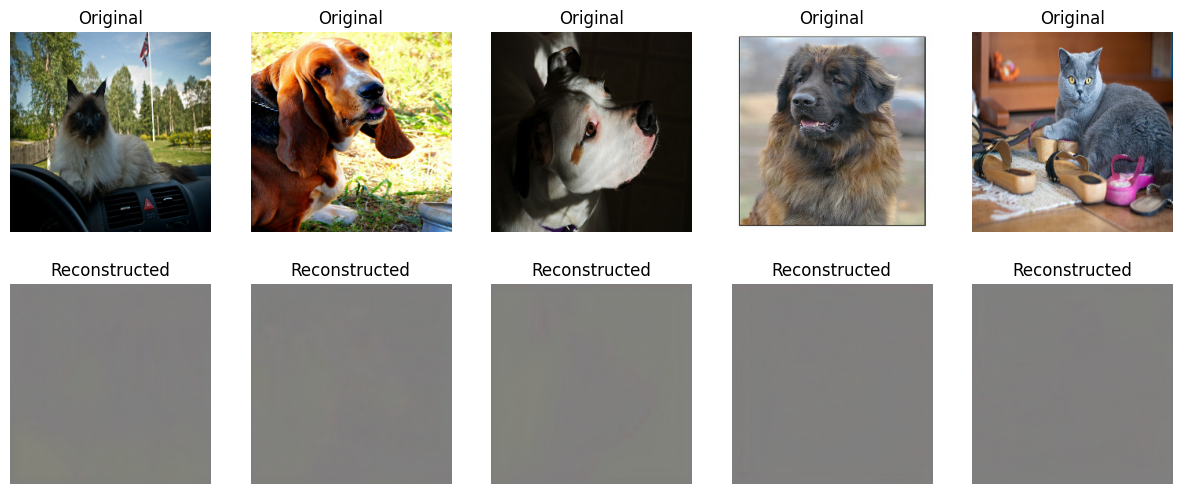

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure model is compiled before inference
autoencoder.compile(optimizer='adam', loss='mse')

# Take a batch of validation images
for batch in val_images.take(1):  
    test_images = batch[0]  # Extract images from dataset

# Convert to numpy and normalize between 0-1 (if necessary)
test_images = test_images.numpy() 

# Get reconstructed images
reconstructed_images = autoencoder.predict(test_images)

# Display original and reconstructed images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):  # Display 5 images
    # Original Image
    axes[0, i].imshow(test_images[i])
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    # Reconstructed Image
    axes[1, i].imshow(reconstructed_images[i])
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


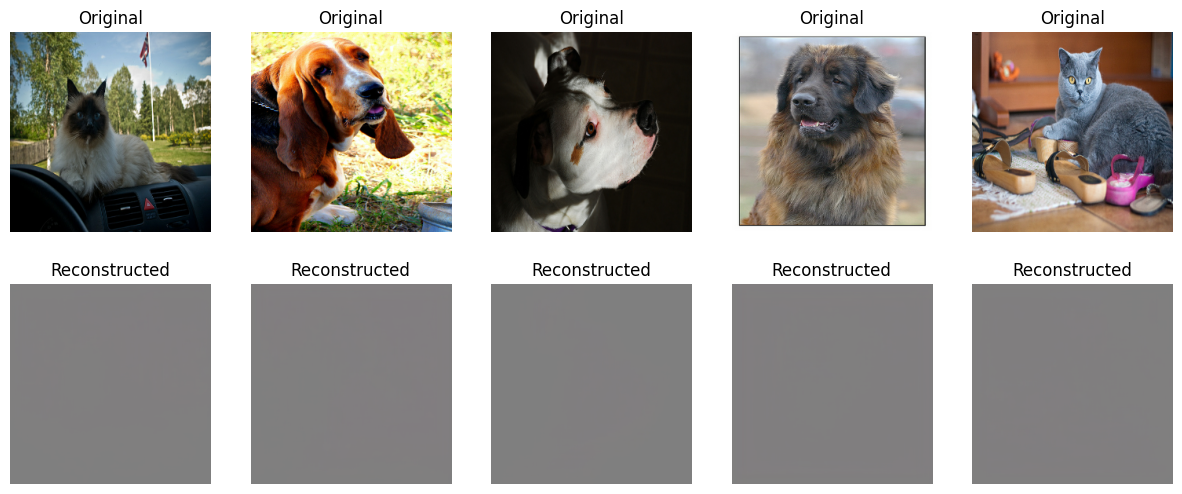

In [ ]:
import matplotlib.pyplot as plt

# Take a batch of images
for batch in val_images.take(1):
    test_images = batch[0]  # Get images from dataset

# Get reconstructed images
reconstructed_images = autoencoder.predict(test_images)

# Display original and reconstructed images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i in range(5):  # Display 5 images
    # Original Image
    axes[0, i].imshow(test_images[i])
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    # Reconstructed Image
    axes[1, i].imshow(reconstructed_images[i])
    axes[1, i].set_title("Reconstructed")
    axes[1, i].axis("off")

plt.show()


Load the Pretrained Encoder for Future Use
Later, when you want to use the encoder for segmentation:

In [ ]:
from tensorflow.keras.models import load_model

# Load the pretrained encoder
pretrained_encoder = load_model('pretrained_encoder.h5')
print("Pretrained Encoder loaded successfully.")


Pretrained Encoder loaded successfully.


In [ ]:
print("Final MSE Loss:", autoencoder.evaluate(val_images))


NameError: name 'autoencoder' is not defined

In [ ]:
from autoencoder import Autoencoder
# Build the segmentation model
autoencoder = Autoencoder()
segmentation_model = autoencoder.build_segmentation_decoder(pretrained_encoder)
